In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)

HEROKU_URL = os.getenv('HEROKU_POSTGRESQL_AMBER_URL')


In [9]:
# Old Static File
# df = pd.read_pickle("/Users/jenniferdimaano/Desktop/GitHub/rescue-chicago/petfinder-data/data/chicago_il_animals_cleaned.pkl")

# New Heroku DB Connection
# https://pandas.pydata.org/docs/reference/api/pandas.read_sql.html
# EXAMPLE: df = pd.read_sql('test_data', 'postgres:///db_name') 
uri = HEROKU_URL 
if uri.startswith("postgres://"):
    uri = uri.replace("postgres://", "postgresql://", 1)
df = pd.read_sql('petfinder_with_dates', uri)  

In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [11]:
df.head()

,index,id,age,gender,size,coat,name,organization_id,organization_name,published_at,status_changed_at,los,breed_primary,breed_secondary,breed_mixed,breed_unknown,color_primary,color_secondary,color_tertiary,good_with_children,good_with_dogs,good_with_cats,attribute_spayed_neutered,attribute_house_trained,attribute_declawed,attribute_special_needs,attribute_shots_current,city,state
0,0,37845448,Young,Female,Small,Medium,Mika,IL608,Friends of Chicago Animal Care & Control,2017-04-13 22:22:16+00:00,2017-05-11 17:41:38+00:00,27,Schnauzer,Poodle,True,False,Gray / Blue / Silver,None,None,False,None,None,True,True,None,False,True,Chicago,IL
1,1,37868394,Young,Female,Small,Long,Luna (LuLu),IL608,Friends of Chicago Animal Care & Control,2017-04-17 21:12:27+00:00,2017-04-25 02:33:04+00:00,7,Shih Tzu,None,False,False,White / Cream,Black,None,None,None,None,True,False,None,False,True,Chicago,IL
2,2,37868562,Adult,Male,Small,Medium,Jack,IL608,Friends of Chicago Animal Care & Control,2017-04-17 21:44:31+00:00,2017-04-25 02:31:52+00:00,7,Maltese,Poodle,True,False,White / Cream,None,None,None,None,None,True,True,None,False,True,Chicago,IL
3,3,38338429,Adult,Male,Small,Short,PinPon,IL608,Friends of Chicago Animal Care & Control,2017-06-07 22:25:36+00:00,2017-08-03 17:02:39+00:00,56,Pug,None,False,False,Yellow / Tan / Blond / Fawn,None,None,False,None,None,True,True,None,False,True,Chicago,IL
4,4,40204215,Adult,Male,Large,Short,Uncle Jesse,IL608,Friends of Chicago Animal Care & Control,2017-12-14 19:41:06+00:00,2018-02-06 19:38:45+00:00,53,Pit Bull Terrier,None,False,False,Gray / Blue / Silver,None,None,None,None,None,True,True,None,False,True,Chicago,IL


In [12]:
# dropping irrelevant columns
df = df.drop(columns=["id", "name", "organization_id", "published_at", "status_changed_at", "attribute_declawed", "city", "state"])

In [13]:
# transform "age" column mapping age and size
age_dict={
'Baby':'0',
'Young':'1',
'Adult':'2',
'Senior':'3'
}
df['age'] = df['age'].map(age_dict).astype(str).astype(int)

In [14]:
# transform "size" column
size_dict={
'Small':'0',
'Medium':'1',
'Large': '2',
'Extra Large': '3'
}
df['size'] = df['size'].map(size_dict).astype(str).astype(int)

In [15]:
# Convert binary columns to binary (0/1) data type
binary_cols = ["breed_mixed", "breed_unknown", "good_with_children", "good_with_dogs", "good_with_cats", "attribute_spayed_neutered",
               "attribute_house_trained", "attribute_shots_current", "attribute_special_needs"]
df[binary_cols] = df[binary_cols].astype(bool).astype(int)

In [16]:
# dummy variables for gender
df['gender'] = df['gender'].replace({"Male": 0, "Female": 1})

In [17]:
# target encoding on larger categorical features
target_cols = ["coat", "organization_name", "breed_primary", "breed_secondary", "color_primary", "color_secondary", "color_tertiary"]
te = ce.TargetEncoder(cols=target_cols)
df[target_cols] = te.fit_transform(df[target_cols], df["los"])

In [18]:
df.describe()

,index,age,size,coat,organization_name,los,breed_primary,breed_secondary,breed_mixed,breed_unknown,color_primary,color_secondary,color_tertiary,good_with_children,good_with_dogs,good_with_cats,attribute_spayed_neutered,attribute_house_trained,attribute_special_needs,attribute_shots_current
count,182152.000000,182152.000000,182152.000000,182152.000000,182152.000000,182152.000000,182152.000000,182152.000000,182152.000000,182152.0,182152.000000,182152.000000,182152.000000,182152.000000,182152.000000,182152.000000,182152.000000,182152.000000,182152.000000,182152.000000
mean,50129.442323,1.072374,1.067987,117.663768,117.608893,117.661222,117.721650,117.693881,0.758454,0.0,117.662144,117.663340,117.676403,0.181557,0.224999,0.097029,0.660986,0.307655,0.015926,0.826996
std,28647.012029,0.903630,0.764601,70.411795,167.303113,308.449533,54.763204,29.032960,0.428021,0.0,92.779774,49.731773,10.923047,0.385480,0.417583,0.295998,0.473376,0.461524,0.125191,0.378252
min,0.000000,0.000000,0.000000,29.097039,11.501305,-1.000000,14.131715,29.911309,0.000000,0.0,37.606426,40.792397,27.024988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25770.750000,0.000000,1.000000,56.520722,28.990442,8.000000,97.470765,115.701104,1.000000,0.0,44.190218,51.162004,119.185699,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,49789.500000,1.000000,1.000000,56.520722,53.240461,20.000000,113.476788,122.791397,1.000000,0.0,59.480904,154.397827,119.185699,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,74990.000000,2.000000,2.000000,192.824294,110.534261,60.000000,129.694064,122.791397,1.000000,0.0,244.569907,154.397827,119.185699,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,99999.000000,3.000000,3.000000,192.824294,1162.010733,5016.000000,665.247273,550.828491,1.000000,0.0,244.569907,154.397827,119.185699,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
def remove_outliers(dataframe, columns):
    for col in columns:
        mean = dataframe[col].mean()
        std = dataframe[col].std()
        z_scores = np.abs((dataframe[col] - mean) / std)
        dataframe = dataframe[z_scores <= 3]
    return dataframe

# Remove outliers from Carats, Price, and Retail using Z-score
df = remove_outliers(df, ['organization_name', 'los', 'breed_primary', 'breed_secondary'])

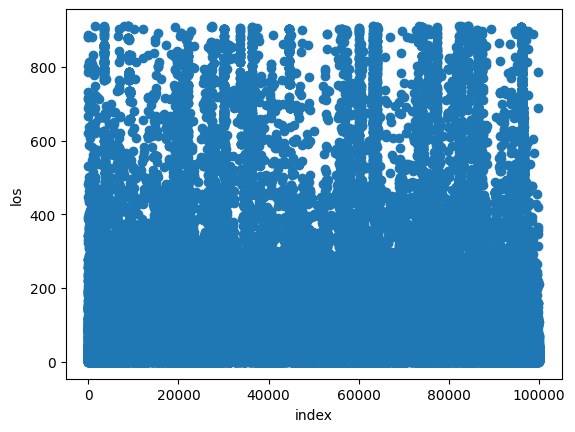

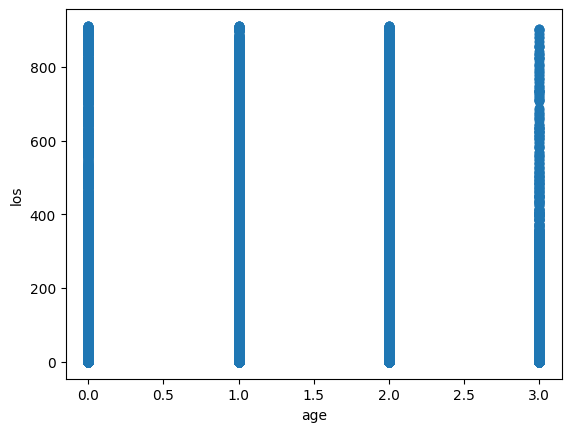

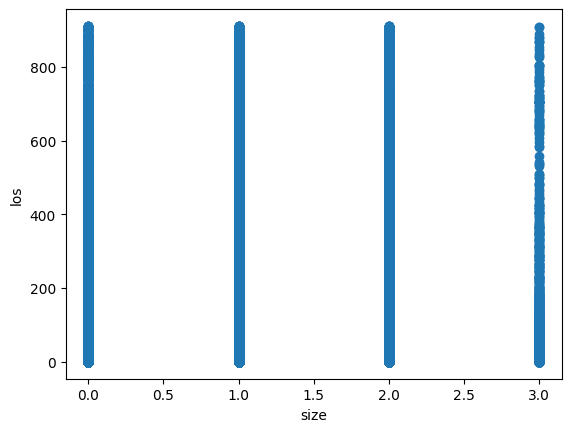

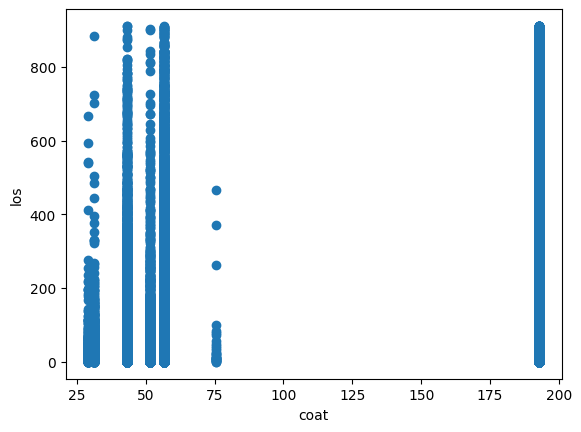

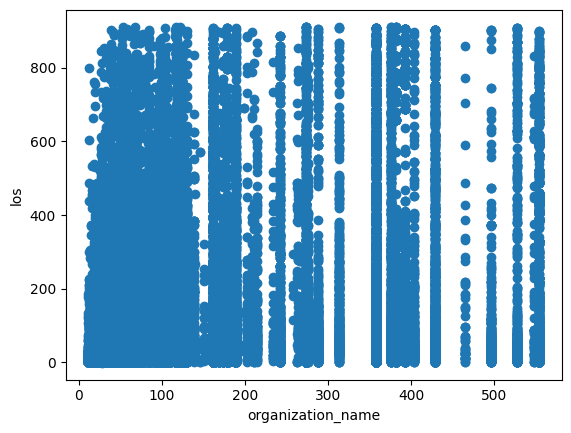

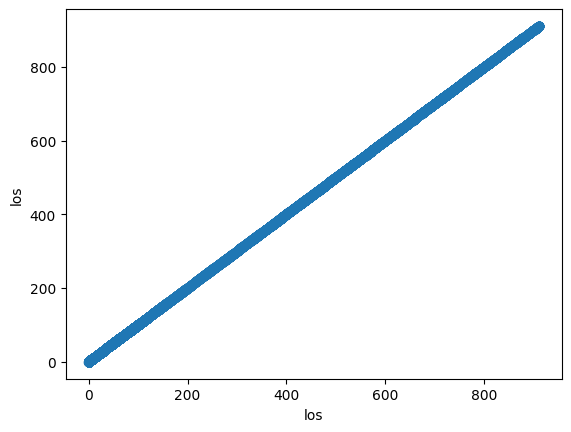

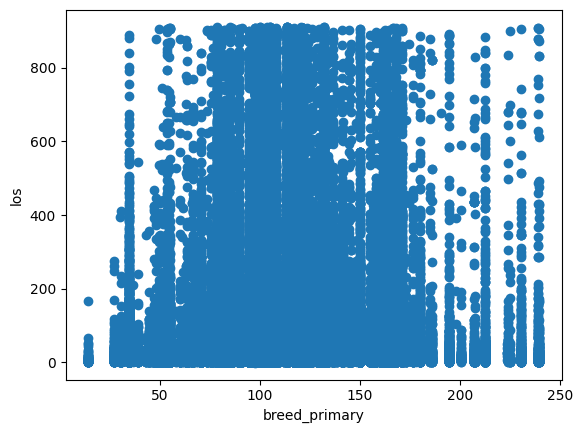

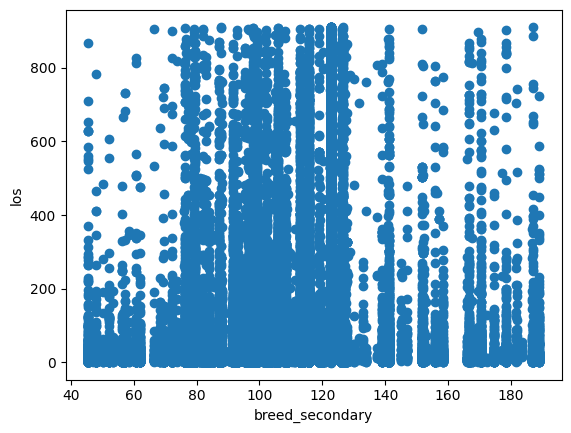

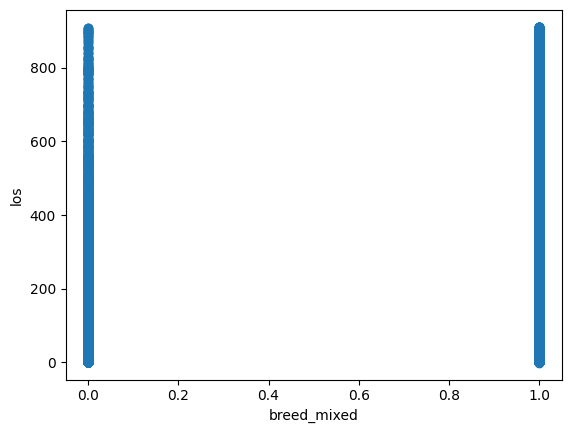

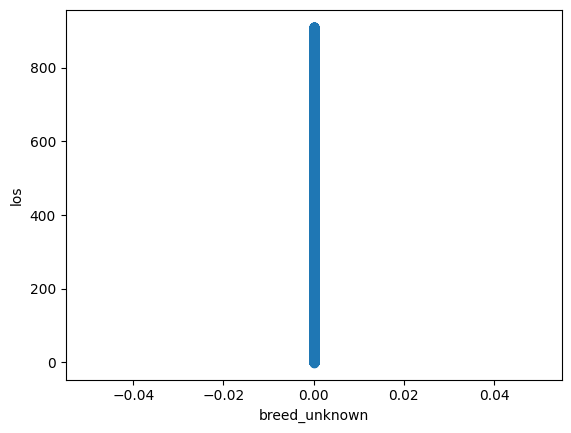

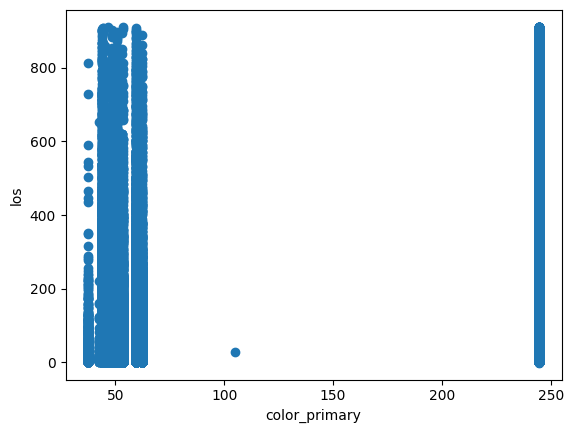

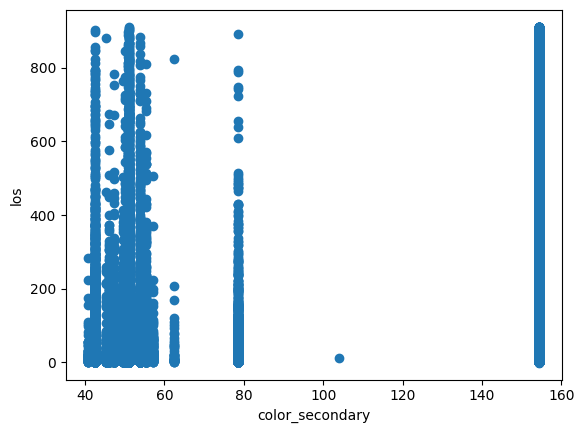

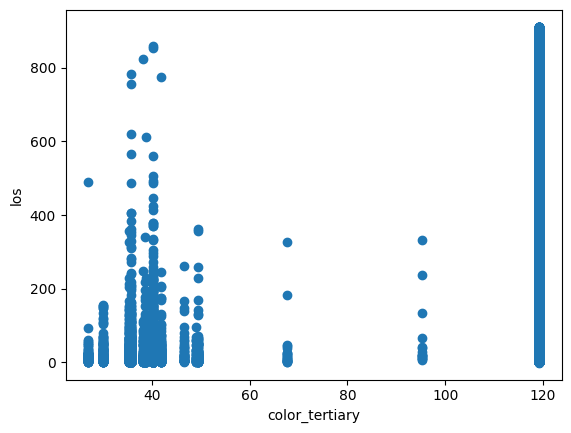

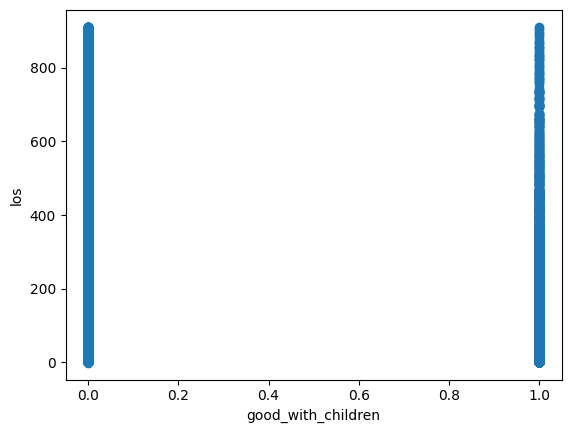

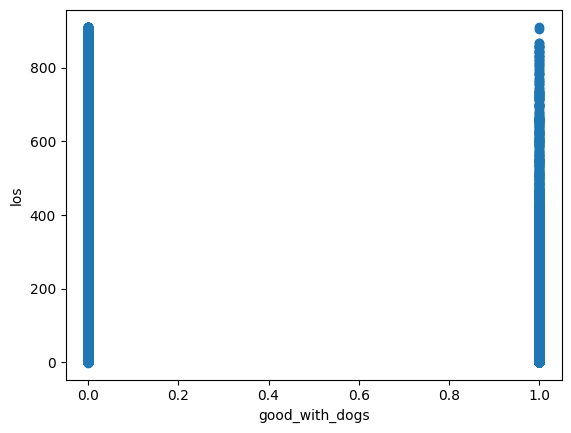

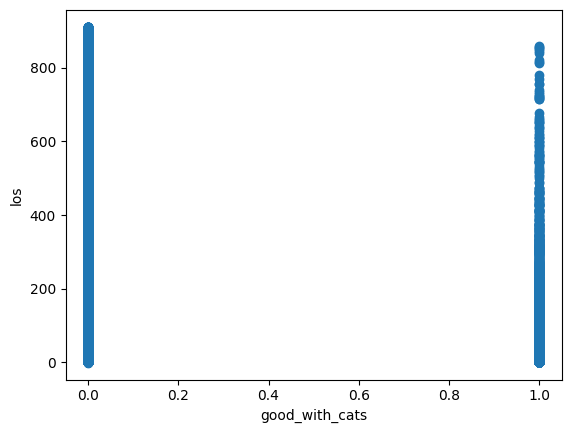

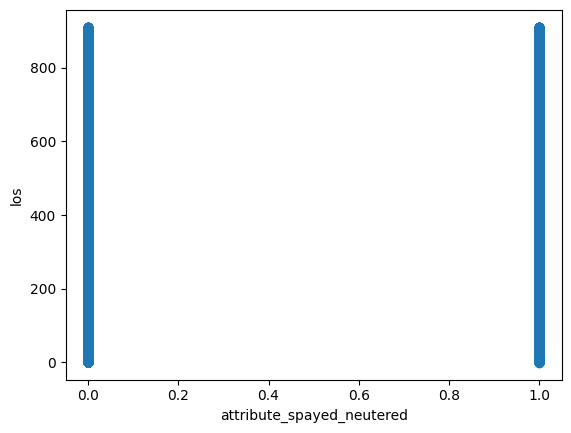

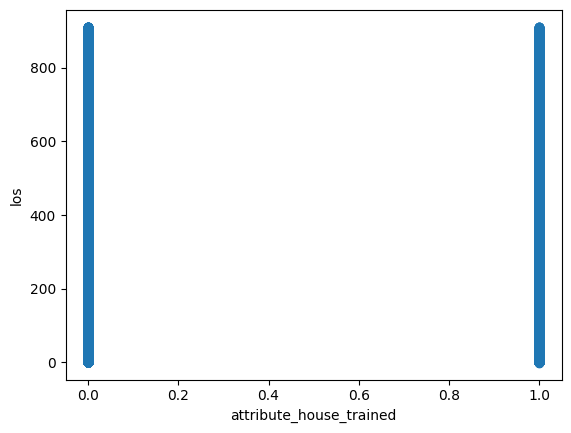

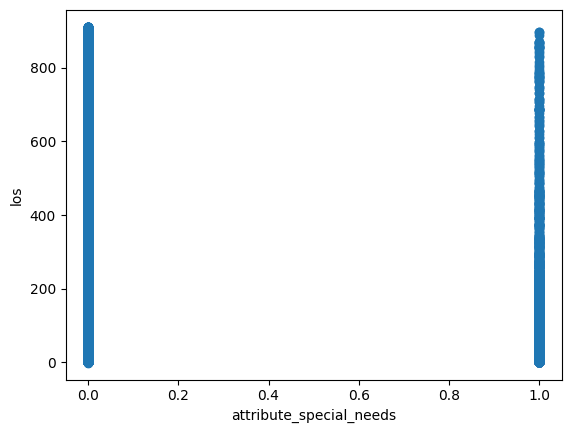

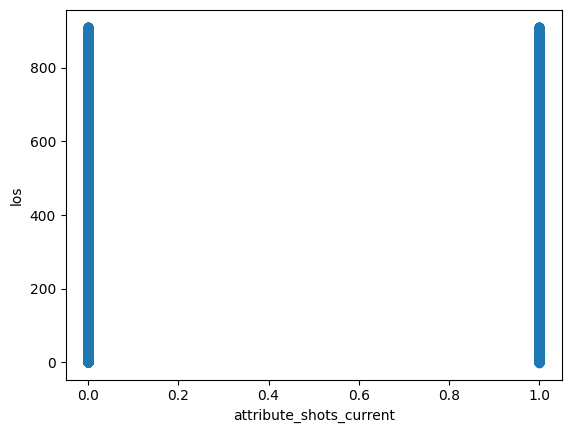

In [20]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()


# Create a scatter plot of numeric features against "los"
for col in num_cols:
    plt.scatter(df[col], df["los"])
    plt.xlabel(col)
    plt.ylabel("los")
    plt.show()


In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2, random_state=42)

In [22]:
# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error of the model
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', np.mean(mae))
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', np.mean(r2))

ValueError: could not convert string to float: 'Unknown'